# Introdution

Thank you Chitta Ranjan for the real world dataset of sheet break on a paper mill. It is a challeging time series dataset and a common problem on predictive maintanance domain.
This article propose a feasible and straight forward solution for the problem.

# Predictive maintanance

On the predictive maintanance domain a challenging that many companies are facing are predict failures 
before its ocurrence based on the equipment behavior (Condition Based Maintanance).
A common tool used today for maintanance crew are risk and realiability tools (based on Weibull curves for example).
Sumarizing: the idea is to separate the failures on a probability curve with 3 distinct areas: premature failures, random failures and 
end of life failures.
This is a simple ideia that can give us insights about features that are important on this domain, such as the clock.

In [1]:
from IPython.core.display import display, HTML
display(HTML('<p align="center"><img border="0" src="https://www.weibull.com/hotwire/issue14/rb14_6.gif" alt="Plot of typical bathtub curve" width="602" height="353"></p>'))

# Exploratory analysys on data

Analysing all the existing features, only x61 is freeze. 

In [7]:
import pandas as pd
df = pd.read_csv('./processminer-rare-event-mts - data.csv',sep=';')
df[df.y==0].describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
count,18274.0,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,...,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.0
mean,0.0,0.011198,0.194998,0.626211,-10.139593,0.006840,2.489880,0.001483,-0.004143,-0.003368,...,0.401567,0.458541,0.183983,2.454428,9.401764,0.236905,-0.001881,-0.069369,0.001252,0.0
std,0.0,0.741833,4.912832,5.898330,130.983772,0.633845,36.987546,0.108664,0.075172,0.155036,...,6.052476,4.612143,3.023366,67.891696,81.289542,2.324591,0.048760,10.428501,0.004718,0.0
min,0.0,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,-0.120087,...,-16.555008,-14.211369,-8.210370,-230.574030,-269.039500,-4.888661,-0.149790,-100.810500,-0.012229,0.0
25%,0.0,-0.405828,-2.123012,-3.477843,-111.428898,-0.446864,-23.687049,-0.058658,-0.050880,-0.059966,...,-3.672684,-1.933476,0.492208,-39.882046,-45.399116,-1.598804,0.000473,0.295016,-0.001808,0.0
50%,0.0,0.128147,-0.060635,-0.161470,-14.940988,-0.120699,10.585686,-0.009339,-0.000993,-0.030057,...,0.294846,0.144222,0.712452,17.633121,1.682657,0.085826,0.012867,0.733812,0.000704,0.0
75%,0.0,0.420588,2.335692,3.443554,92.052390,0.326277,32.206184,0.060506,0.038986,0.001255,...,5.132737,3.237362,2.676296,44.113162,63.318964,2.222118,0.020988,1.266258,0.004064,0.0
max,0.0,3.054156,16.742105,15.900116,334.694098,2.371770,96.060768,1.705590,0.553834,4.060033,...,14.180588,11.148006,6.637265,287.252017,252.147455,6.922008,0.067249,6.985460,0.020510,0.0


Althought x61 has a small std it has some information.

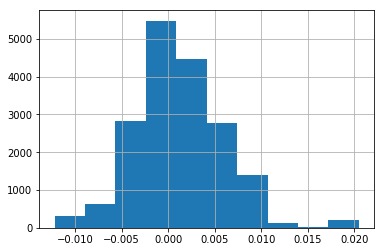

In [8]:
import matplotlib.pyplot as plt 

df['x60'].loc[df.y==0].hist()
plt.show()

# Data preparation and feature enginerring

From the Predictive Maintanance insight a feature that is missing is the clock or the cycle since the last break. 
It is a usefull information for the model to contextualized the anomalies on time.

In [9]:
from src.pyUtil import *
df = count_change(df,'y','count_y')

The purpose is to create an alert until 4 minutes before the break and eliminate the freezed feature(x61). 

In [14]:
df['y_1'] = df['y'].shift(-1)
df['y_2'] = df['y'].shift(-2)
df['y_3'] = df['y'].shift(-3)
df = df.loc[df.y==0] #deleting the downtime event 

df['y'] = df.apply(lambda x: 1 if ((x['y_1'] == 1) | (x['y_2'] == 1)) else 0, axis=1) 

features = df.columns.tolist()# adding delayed info
features.remove('time')
features.remove('y_1')
features.remove('y_2')
features.remove('y_3')
features.remove('x61')
target = 'y'
features.remove(target)

c:\users\z003z3rv\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Some hightlights: the time features were eliminated since the period of data (less than a month) do note justify 
create features like (hour, day, shift, quarter, day of week, etc.)

The minory class is ~ 1.3% of all data:

In [7]:
df.y.value_counts()[1] /(df.y.value_counts()[0] + df.y.value_counts()[1])

0.013516471489547991

A very simple way to improve it a bit is to determine that 6 minutes before the event is as good as 4 minutes. 
So, it will improve 50% of minority class and it is fair to assert that is not a terible sin.

In [8]:
df['y'] = df.apply(lambda x: 1 if ((x['y_1'] == 1) | (x['y_2'] == 1) | (x['y_3'] == 1) ) else 0, axis=1) 

Some improvement on the unbalanced class:

In [9]:
df.y.value_counts()[1] /(df.y.value_counts()[0] + df.y.value_counts()[1])

0.020192623399365218

In [10]:
print(features)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'count_y']


This artificial features has the following behavior:

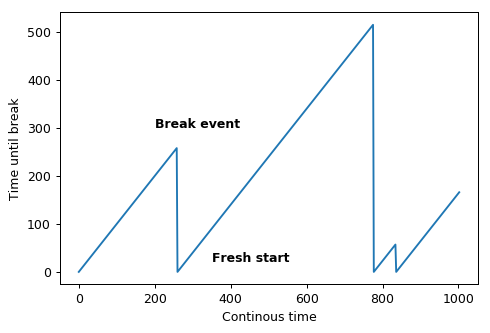

In [11]:
plt.figure(dpi=90)
plt.plot(df['count_y'].iloc[0:1000])
plt.ylabel('Time until break')
plt.xlabel('Continous time')
plt.text(200,300,'Break event',weight='bold')
plt.text(350,20,'Fresh start',weight='bold')
plt.show()

Behavior of counter or clock since the last break.

In [12]:
df[['y','count_y']].iloc[253:263]

,y,count_y
253,0,253
254,0,254
255,0,255
256,1,256
257,1,257
258,1,258
260,0,0
261,0,1
262,0,2
263,0,3


We will carry historical (10 minutes) information of the frame for a future analyis before splitting the data. It will be explained later.

In [13]:
df = df.join(df.shift(1),rsuffix='_1').join(df.shift(2),rsuffix='_2').join(df.shift(3),rsuffix='_3').join(df.shift(4),rsuffix='_4').join(df.shift(5),rsuffix='_5')
df.dropna(inplace=True)

It will be divides in train and test (without cross validation to simplify the approach). Test size at default 0.25.

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df[features],df[target],
                                                    shuffle=True, random_state=10)
#Have a copy of the vector, just in case
x_train_origin = x_train.copy()
x_test_origin = x_test.copy()

Scaling the data:

In [16]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

x_train = pd.DataFrame(data=scale.fit_transform(x_train),columns=features,index=y_train.index)
x_test = pd.DataFrame(data=scale.transform(x_test),columns=features,index=y_test.index)

# Anomaly detection with one class strategy

The simplest strategy for anomaly detection is to use one class algoritms such as SVM or Mahalanobis distance to 
understand what is normal in data and what is not normal. Somehow is the same with autoenconders used on the Chitta article.

Using the anomaly detector alone and with all features the results are bellow the benchmark of F1 = 0.1

In [17]:
#Selecting data
xy_train = x_train.join(y_train)
xy_train = xy_train.loc[(xy_train.y==0)]  # only normal

x_train_pos, x_test_pos, y_train_pos, y_test_pos = train_test_split(xy_train[features], xy_train[target], shuffle=True,
                                                                    train_size=0.9, random_state=10)

In [18]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

svm1 = OneClassSVM(kernel='rbf', gamma='auto',nu=0.05)

svm1.fit(x_train_pos[features])

y_pred = pd.DataFrame(data=svm1.predict(x_test[features]))
# need to convert to the same standard, 0 == normal and 1 for break
y_pred.loc[y_pred[0]==1] = 0 # normal 
y_pred.loc[y_pred[0]==-1] = 1 #break

print(classification_report(y_test,y_pred,digits=3))
confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0      0.984     0.947     0.965      4486
           1      0.040     0.123     0.061        81

    accuracy                          0.933      4567
   macro avg      0.512     0.535     0.513      4567
weighted avg      0.967     0.933     0.949      4567



array([[4249,  237],
       [  71,   10]], dtype=int64)

Using Mahalanobis One Class measuring the distance from the mean of the training data. There more sofisticated approaches 
but for this article we will apply a simpler solution

Defining Mahalanobis One Class 

In [56]:
from scipy.stats import chi2
import scipy as sp

def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    based on https://www.machinelearningplus.com/statistics/mahalanobis-distance/
    """
    x_minus_mu = x - np.mean(data).values.reshape(1,-1)#np.mean(data)
    
    if not cov:
        cov = np.cov(data.values.T)
    if cov.shape == (): #Maha in 1 dimension
        cov = cov.reshape(1,1)
    inv_covmat = sp.linalg.inv(cov)
   
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

class MahalanobisOneclassClassifier():
    def __init__(self, xtrain, significance_level=0.01):
        self.xtrain = xtrain
        self.critical_value = chi2.ppf((1-significance_level), df=xtrain.shape[1]-1)
        #print('Critical value is: ', self.critical_value)

    def predict_proba(self, xtest):
        mahalanobis_dist = mahalanobis(xtest, self.xtrain)
        self.pvalues = 1 - chi2.cdf(mahalanobis_dist, 2)
        return mahalanobis_dist

    def predict(self, xtest):
        return np.array([int(i) for i in self.predict_proba(xtest) > self.critical_value])

In [20]:
clf_total = MahalanobisOneclassClassifier(x_train_pos[features], significance_level=0.001)
mahalanobis_dist_total = clf_total.predict_proba(x_test_pos[features].values)

print(classification_report(y_test,clf_total.predict(x_test[features].values),digits=3))
confusion_matrix(y_test,clf_total.predict(x_test[features].values))

              precision    recall  f1-score   support

           0      0.984     0.886     0.932      4486
           1      0.032     0.210     0.056        81

    accuracy                          0.874      4567
   macro avg      0.508     0.548     0.494      4567
weighted avg      0.967     0.874     0.917      4567



array([[3973,  513],
       [  64,   17]], dtype=int64)

### Small feature groups for anomaly detection

Both algoritms were bellow benchmark alone using all the features. The dimension of the problem is surelly a complication
for this type of algorithm. One possible strategy is to divide the features into afinity groups. Usually a good working session
with the domain expert can help with that. An alternative is to use the GradientBoost Tree (features importance) to support
this definition.

In [21]:
from xgboost import XGBClassifier, plot_importance
gbc = XGBClassifier(n_estimators=1000,subsample=0.9,max_depth=6,random_state=10, max_features=0.9,n_jobs=2)

In [22]:
%time gbc.fit(x_train,y_train)

Wall time: 55.6 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=6, max_features=0.9, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=2, nthread=None,
              objective='binary:logistic', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.9)

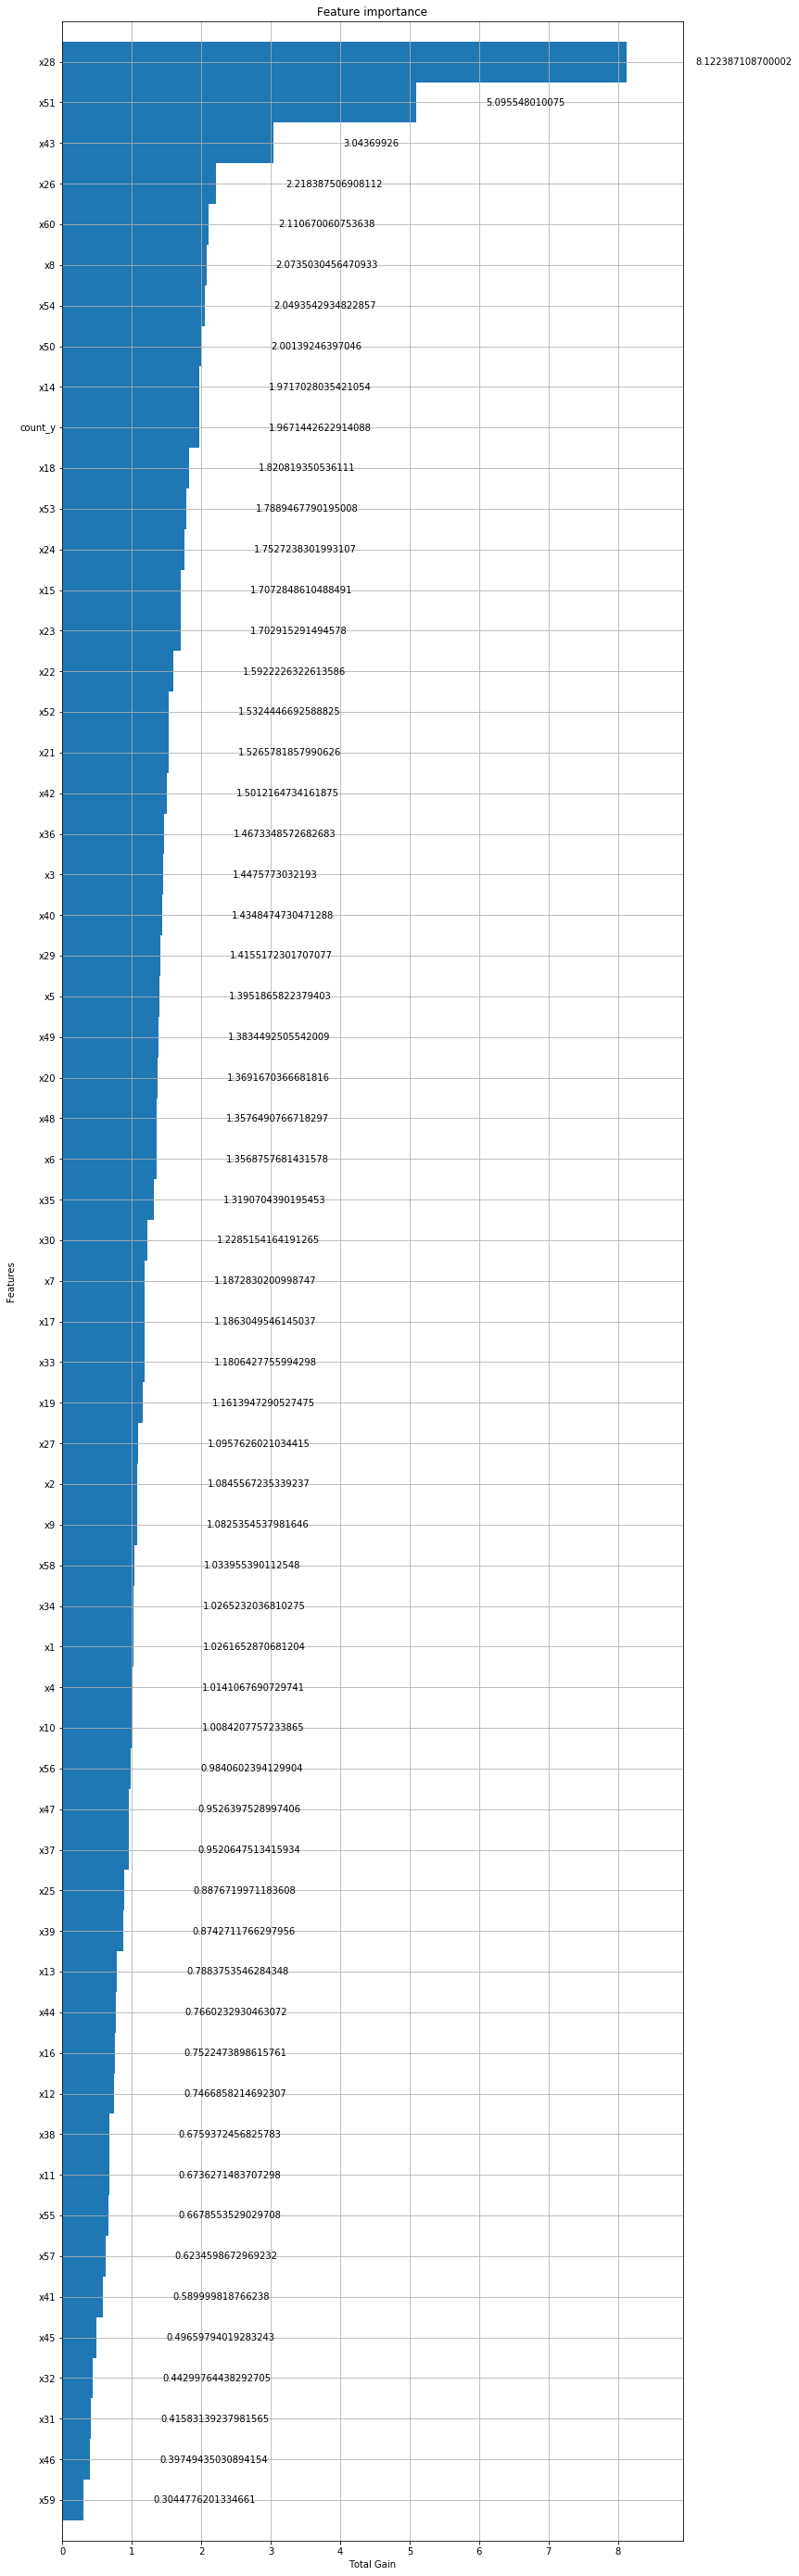

In [23]:
fig, ax = plt.subplots(1,1,figsize=(12,50))
plot_importance(gbc, ax=ax, height=1, importance_type="gain", xlabel="Total Gain")

It will be create groups of 2 tags for the top 20 indicated by the GradientBoost:(arbirtrary) 

In [24]:
feat_maha = ['x51', 'x28']
feat_maha2 = ['x26', 'x43']
feat_maha3 = ['x60', 'x8']
feat_maha4 = ['x54', 'x50']
feat_maha5 = ['x14', 'x18']
feat_maha6 = ['x24', 'x53']
feat_maha7 = ['x23', 'x15']
feat_maha8 = ['x22', 'x52']
feat_maha9 = ['x42', 'x21']
feat_maha10 = ['x36', 'x3']

In [25]:
# Defining the models              
clf = MahalanobisOneclassClassifier(x_train_pos[feat_maha], significance_level=0.01)
clf2 = MahalanobisOneclassClassifier(x_train_pos[feat_maha2], significance_level=0.01)
clf3 = MahalanobisOneclassClassifier(x_train_pos[feat_maha3], significance_level=0.01)
clf4 = MahalanobisOneclassClassifier(x_train_pos[feat_maha4], significance_level=0.01)
clf5 = MahalanobisOneclassClassifier(x_train_pos[feat_maha5], significance_level=0.01)
clf6 = MahalanobisOneclassClassifier(x_train_pos[feat_maha6], significance_level=0.01)
clf7 = MahalanobisOneclassClassifier(x_train_pos[feat_maha7], significance_level=0.01)
clf8 = MahalanobisOneclassClassifier(x_train_pos[feat_maha8], significance_level=0.01)
clf9 = MahalanobisOneclassClassifier(x_train_pos[feat_maha9], significance_level=0.01)
clf10 = MahalanobisOneclassClassifier(x_train_pos[feat_maha10], significance_level=0.01)

In [26]:
#stacking with gradient boost
df['maha_dist'] = clf.predict_proba(df[feat_maha].values)
df['maha_dist2'] = clf2.predict_proba(df[feat_maha2].values)
df['maha_dist3'] = clf3.predict_proba(df[feat_maha3].values)
df['maha_dist4'] = clf4.predict_proba(df[feat_maha4].values)
df['maha_dist5'] = clf5.predict_proba(df[feat_maha5].values)
df['maha_dist6'] = clf6.predict_proba(df[feat_maha6].values)
df['maha_dist7'] = clf7.predict_proba(df[feat_maha7].values)
df['maha_dist8'] = clf8.predict_proba(df[feat_maha8].values)
df['maha_dist9'] = clf9.predict_proba(df[feat_maha9].values)
df['maha_dist10'] = clf10.predict_proba(df[feat_maha10].values)

new_features = []
for i in df.columns.tolist()[-10:]:
    if not i in features:
        features.append(i)
        new_features.append(i)

In [27]:
print(features)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'count_y', 'maha_dist', 'maha_dist2', 'maha_dist3', 'maha_dist4', 'maha_dist5', 'maha_dist6', 'maha_dist7', 'maha_dist8', 'maha_dist9', 'maha_dist10']


We created many features on the dataset based on group based anomaly detection. This features will be provided as inputs of
a final model. It will be apply GradientBoost again.

In [28]:
gbc = XGBClassifier(n_estimators=1000,subsample=0.9,max_depth=6,random_state=10, max_features=0.9, n_jobs=2)

Keeping the same random state of train_test_split can garantee that the split is repetible.

In [29]:
x_train, x_test, y_train, y_test = train_test_split(df[features],df[target],
                                                    shuffle=True, random_state=10)

Checking the last statement ... just in case

In [30]:
(x_train.index == x_train_origin.index).sum() / (x_train.index == x_train_origin.index).shape[0]

1.0

In [31]:
%time gbc.fit(x_train,y_train)

Wall time: 1min 2s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=6, max_features=0.9, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=2, nthread=None,
              objective='binary:logistic', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.9)

In [32]:
print(classification_report(y_test,gbc.predict(x_test[features]),digits=3))
confusion_matrix(y_test,gbc.predict(x_test[features]))

              precision    recall  f1-score   support

           0      0.989     1.000     0.994      4486
           1      0.968     0.370     0.536        81

    accuracy                          0.989      4567
   macro avg      0.978     0.685     0.765      4567
weighted avg      0.988     0.989     0.986      4567



array([[4485,    1],
       [  51,   30]], dtype=int64)

### Anomaly detection for each feature

Another strategy is creating AD for each variable (Feature) on the model input using the same top 20 tags for that.

In [85]:
#top 20 tags
original_features = ['count_y','x51', 'x28','x26', 'x43','x60', 'x8','x54', 'x50','x14', 'x18','x24', 'x53','x23', 'x15','x22', 'x52','x42', 'x21', 'x36', 'x3']
#original_features =[i for i in features if i not in new_features] #all tags
features_individual_ad = original_features.copy()
ad_maha = []
for feat in original_features:
    if not feat == 'count_y':
        _model = MahalanobisOneclassClassifier(x_train_pos[[feat]], significance_level=0.01)
        ad_maha.append(_model)
        _ad_name = feat + '_ad'
        df[_ad_name] = _model.predict_proba(df[[feat]].values)
        features_individual_ad.append(_ad_name)

In [86]:
x_train_ad, x_test_ad, y_train_ad, y_test_ad = train_test_split(df[features_individual_ad],df[target],
                                                    shuffle=True, random_state=10)

In [97]:
from sklearn.preprocessing import StandardScaler
scale_ad = StandardScaler()

x_train_ad = pd.DataFrame(data=scale_ad.fit_transform(x_train_ad),columns=features_individual_ad,index=y_train_ad.index)
x_test_ad = pd.DataFrame(data=scale_ad.transform(x_test_ad),columns=features_individual_ad,index=y_test_ad.index)

In [98]:
gbc_ad = XGBClassifier(n_estimators=1000,subsample=0.9,max_depth=6,random_state=10, max_features=0.9, n_jobs=2)
%time gbc_ad.fit(x_train_ad,y_train_ad)

Wall time: 40 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=6, max_features=0.9, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=2, nthread=None,
              objective='binary:logistic', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.9)

In [99]:
print(classification_report(y_test,gbc_ad.predict(x_test_ad[features_individual_ad]),digits=3))
confusion_matrix(y_test,gbc_ad.predict(x_test_ad[features_individual_ad]))

              precision    recall  f1-score   support

           0      0.992     0.998     0.995      4486
           1      0.865     0.556     0.677        81

    accuracy                          0.991      4567
   macro avg      0.929     0.777     0.836      4567
weighted avg      0.990     0.991     0.990      4567



array([[4479,    7],
       [  36,   45]], dtype=int64)

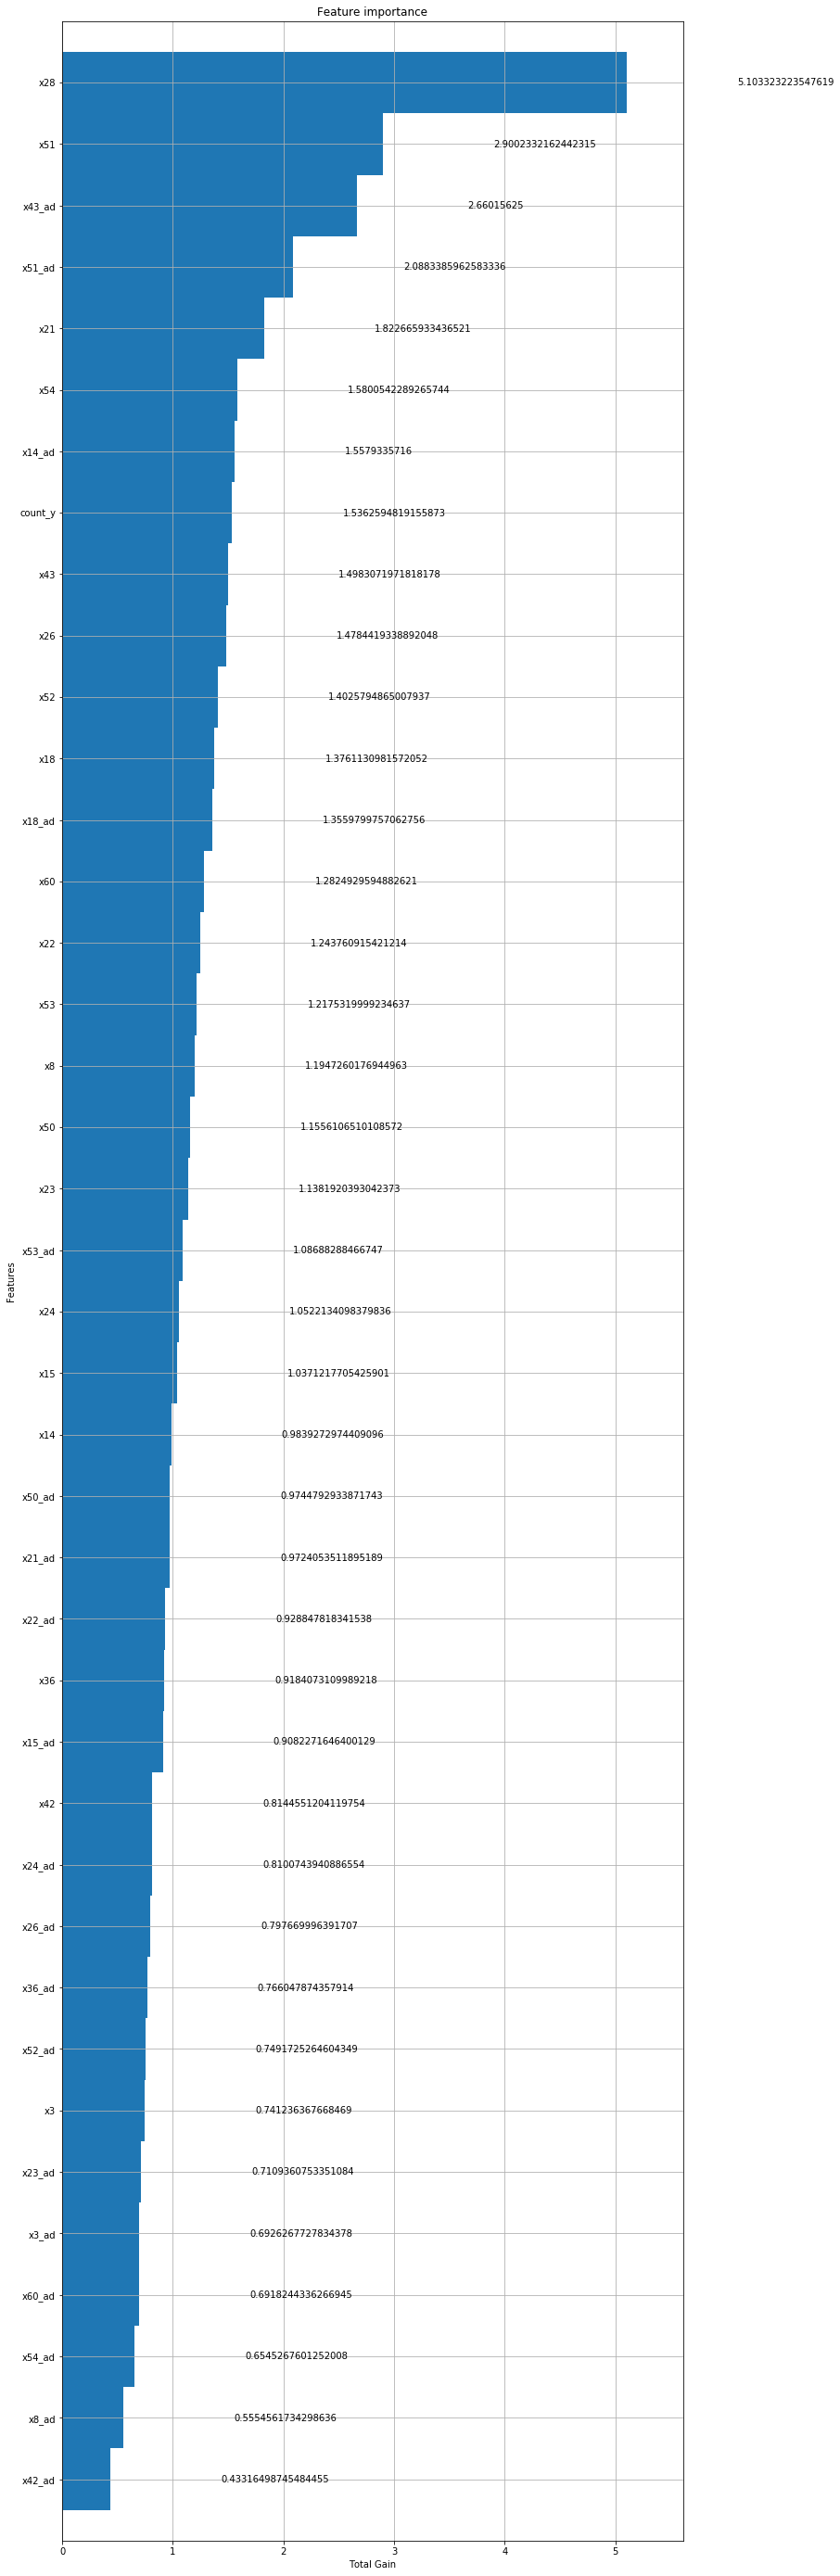

In [100]:
fig, ax = plt.subplots(1,1,figsize=(12,50))
plot_importance(gbc_ad, ax=ax, height=1, importance_type="gain", xlabel="Total Gain")